# Face Detection
- OpenCV DNN: 25-30 FPS on i7x12

In [33]:
%reload_ext autoreload
%autoreload 2
import os, sys
from os.path import join
import time
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

import numpy as np
import imutils
import cv2 as cv

# append notebook imports folder
sys.path.append(str(Path(os.getcwd()).parent))
from utils import imx

# append vframe imports folder
sys.path.append(str(Path(os.getcwd()).parent.parent/'vframe/'))
from vframe.utils import im_utils, file_utils
from vframe.settings import vframe_cfg as cfg

In [56]:
# get a test image
print(cfg.DIR_TEST_IMAGES)
im_test_list = glob(join(cfg.DIR_TEST_IMAGES, 'faces', '*'))
print('found {} images'.format(len(im_test_list)))
def random_image():
  return np.random.choice(im_test_list)

def perf_times(t, iters):
  te = (time.time() - t) / iters
  fps = iters / (time.time() - t)
  print('time: {:.2f}, {:.2f} FPS'.format(te,fps))

/data_store_hdd/apps/syrianarchive/test/images
found 1 images


# OpenCV DNN Caffe Face Detector

In [15]:
fp_prototxt = join(cfg.DIR_MODELS_CAFFE, 'opencv_dnn', 'opencv_face_detector.prototxt')
fp_model = join(cfg.DIR_MODELS_CAFFE, 'opencv_dnn', 'opencv_face_detector.caffemodel')
dnn_thresh = 0.5
dnn_scale = 1.0
dnn_mean = (104.0, 177.0, 123.0)
dnn_size = (300, 300)

In [6]:
net = cv.dnn.readNetFromCaffe(fp_prototxt, fp_model)

In [57]:
# load the input image and construct an input blob for the image
# by resizing to a fixed 300x300 pixels and then normalizing it
im = cv.imread(random_image())
dst = im.copy()
(h, w) = im.shape[:2]
blob = cv.dnn.blobFromImage(cv.resize(im, dnn_size), dnn_scale, dnn_size, dnn_mean)
iters = 10

import time
st = time.time()
for i in range(iters):
  net.setInput(blob)
  detections = net.forward()
perf_times(st, iters)

time: 0.04, 27.21 FPS


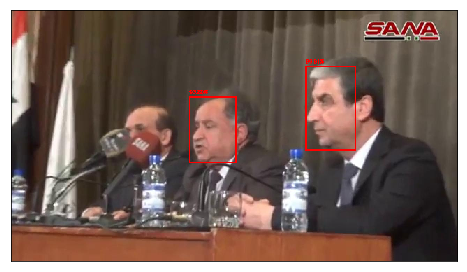

<Figure size 432x288 with 0 Axes>

In [32]:
# plot it
# loop over the detections
for i in range(0, detections.shape[2]):
  # extract the confidence (i.e., probability) associated with the
  # prediction
  confidence = detections[0, 0, i, 2]

  # filter out weak detections by ensuring the `confidence` is
  # greater than the minimum confidence
  if confidence > dnn_thresh:
    # compute the (x, y)-coordinates of the bounding box for the
    # object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    # draw the bounding box of the face along with the associated
    # probability
    text = "{:.2f}%".format(confidence * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv.rectangle(dst, (startX, startY), (endX, endY),
        (0, 0, 255), 4)
    cv.putText(dst, text, (startX, y),
    cv.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

imx.pltimg(dst, mode='bgr')

# DLIB HoG Detector
- 7 FPS but during other processing (not using GPU)

In [66]:
dlib_hog_predictor = dlib.get_frontal_face_detector()

In [71]:
iters = 10
st = time.time()
for i in range(iters):
  dets = dlib_hog_predictor.run(im_dlib, 0)
perf_times(st, iters)

print(dets)

time: 0.11, 8.82 FPS
(rectangles[[(476, 277) (626, 427)], [(808, 211) (958, 360)]], [0.8904476319618646, 0.13861323941425718], [1, 1])


# DLIB CNN Detector
- 7-8 FPS with CUDNN enabled pyramid=1
- 32 FPS with CUDNN enabled pyramid=0
- 72 FPS with CNN batch size 128

In [95]:
import dlib
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
cnn_face_detector = dlib.cnn_face_detection_model_v1(cfg.DIR_MODELS_DLIB_CNN)

In [74]:
#im_dlib = dlib.load_rgb_image(random_image())
im_dlib = cv.cvtColor(im, cv.COLOR_BGR2RGB)
h, w = im_dlib.shape[:2]
im_dlib = cv.resize(im_dlib, (w//2, h//2))

In [90]:
print(im_dlib.shape)

(360, 640, 3)


In [77]:
help(cnn_face_detector)

Help on cnn_face_detection_model_v1 in module dlib object:

class cnn_face_detection_model_v1(pybind11_builtins.pybind11_object)
 |  This object detects human faces in an image.  The constructor loads the face detection model from a file. You can download a pre-trained model from http://dlib.net/files/mmod_human_face_detector.dat.bz2.
 |  
 |  Method resolution order:
 |      cnn_face_detection_model_v1
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(...)
 |      __call__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __call__(self: dlib.cnn_face_detection_model_v1, imgs: list, upsample_num_times: int=0, batch_size: int=128) -> std::vector<std::vector<dlib::mmod_rect, std::allocator<dlib::mmod_rect> >, std::allocator<std::vector<dlib::mmod_rect, std::allocator<dlib::mmod_rect> > > >
 |      
 |      takes a list of images as input returning a 2d list of mmod rectangles
 |      
 |      2. __call__(sel

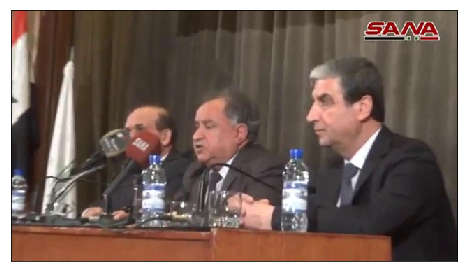

<Figure size 432x288 with 0 Axes>

In [96]:
iters = 128
ims = [im_dlib.copy() for i in range(iters)]
imx.pltimg(ims[0])

In [97]:
st = time.time()
dets = cnn_face_detector(ims, 0)
perf_times(st, iters)

time: 0.01, 72.10 FPS


In [76]:
iters = 100
st = time.time()
for i in range(iters):
  dets = cnn_face_detector(im_dlib, 0)
perf_times(st, iters)

time: 0.03, 32.50 FPS


In [64]:
print(dets)

mmod_rectangles[[(822, 200) (986, 363)], [(505, 294) (641, 431)], [(321, 309) (416, 404)]]
